### Vintage Analysis의 사전 이해

Vintage Analysis: 신용 위험을 관리하는 널리 쓰이는 방법  

Charge-off ratio = "회수되지 않은 금액 / 예상 회수 금액"  
Charge-off ratio를 통해 대출 또는 여신의 부실 위험을 평가  

높은 charge-off ratio는 높은 부실 위험을 의미

### Data 불러오기

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg' # 그래픽 출력 형식을 'svg' 형식(그래픽 확대/축소에 따른 품질 손실이 없어서 주로 고품질의 그래픽 필요할 때 사용)

import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd    
import matplotlib.pyplot as plt
from lifelines import NelsonAalenFitter, CoxPHFitter, KaplanMeierFitter
from lifelines.statistics import logrank_test


pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 100)
credit = pd.read_csv('C:/Users/wjsru/Desktop/데이터 취업 스쿨/머신러닝 프로젝트/Data/credit_record.csv')  
application = pd.read_csv('C:/Users/wjsru/Desktop/데이터 취업 스쿨/머신러닝 프로젝트/Data/application_record.csv') 

In [2]:
credit

,ID,MONTHS_BALANCE,STATUS
0,5001711,0,X
1,5001711,-1,0
2,5001711,-2,0
3,5001711,-3,0
4,5001712,0,C
...,...,...,...
1048570,5150487,-25,C
1048571,5150487,-26,C
1048572,5150487,-27,C
1048573,5150487,-28,C


In [3]:
application

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
438552,6840104,M,N,Y,0,135000.0,Pensioner,Secondary / secondary special,Separated,House / apartment,-22717,365243,1,0,0,0,NaN,1.0
438553,6840222,F,N,N,0,103500.0,Working,Secondary / secondary special,Single / not married,House / apartment,-15939,-3007,1,0,0,0,Laborers,1.0
438554,6841878,F,N,N,0,54000.0,Commercial associate,Higher education,Single / not married,With parents,-8169,-372,1,1,0,0,Sales staff,1.0
438555,6842765,F,N,Y,0,72000.0,Pensioner,Secondary / secondary special,Married,House / apartment,-21673,365243,1,0,0,0,NaN,2.0


In [4]:
# how many unique ID in application record?
len(set(application['ID']))

438510

In [5]:
# how many unique ID in credit record?
len(set(credit['ID']))

45985

In [6]:
# how many IDs do two tables share?
len(set(application['ID']).intersection(set(credit['ID'])))

36457

application과 credit 테이블에서 ID 컬럼을 기준으로 연결시키면,  
사실상 사용할 수 있는 row는 36,457개의 데이터이다.

### Vintage Analysis
**참고 링크: https://listendata.com/2019/09/credit-risk-vintage-analysis.html**

In [7]:
grouped = credit.groupby('ID')

### convert credit data to wide format which every ID is a row
pivot_tb = credit.pivot(index = 'ID', columns = 'MONTHS_BALANCE', values = 'STATUS')
pivot_tb['open_month'] = grouped['MONTHS_BALANCE'].min() # smallest value of MONTHS_BALANCE, is the month when loan was granted
pivot_tb['end_month'] = grouped['MONTHS_BALANCE'].max() # biggest value of MONTHS_BALANCE, might be observe over or canceling account
pivot_tb['ID'] = pivot_tb.index
pivot_tb = pivot_tb[['ID', 'open_month', 'end_month']]

# calculate observe window
pivot_tb['window'] = pivot_tb['end_month'] - pivot_tb['open_month']
pivot_tb.reset_index(drop = True, inplace = True) # Index column에 'MONTHS_BALANCE'는 pivot의 column 표시인 것으로 무시.
pivot_tb

MONTHS_BALANCE,ID,open_month,end_month,window
0,5001711,-3,0,3
1,5001712,-18,0,18
2,5001713,-21,0,21
3,5001714,-14,0,14
4,5001715,-59,0,59
...,...,...,...,...
45980,5150482,-28,-11,17
45981,5150483,-17,0,17
45982,5150484,-12,0,12
45983,5150485,-1,0,1


In [8]:
credit

,ID,MONTHS_BALANCE,STATUS
0,5001711,0,X
1,5001711,-1,0
2,5001711,-2,0
3,5001711,-3,0
4,5001712,0,C
...,...,...,...
1048570,5150487,-25,C
1048571,5150487,-26,C
1048572,5150487,-27,C
1048573,5150487,-28,C


In [9]:
pivot_tb

MONTHS_BALANCE,ID,open_month,end_month,window
0,5001711,-3,0,3
1,5001712,-18,0,18
2,5001713,-21,0,21
3,5001714,-14,0,14
4,5001715,-59,0,59
...,...,...,...,...
45980,5150482,-28,-11,17
45981,5150483,-17,0,17
45982,5150484,-12,0,12
45983,5150485,-1,0,1


In [10]:
# credit 테이블에 pivot_tb을 ID 컬럼 기준으로 병합
credit = pd.merge(credit, pivot_tb, on = 'ID', how = 'left')
credit0 = credit.copy()
credit

,ID,MONTHS_BALANCE,STATUS,open_month,end_month,window
0,5001711,0,X,-3,0,3
1,5001711,-1,0,-3,0,3
2,5001711,-2,0,-3,0,3
3,5001711,-3,0,-3,0,3
4,5001712,0,C,-18,0,18
...,...,...,...,...,...,...
1048570,5150487,-25,C,-29,0,29
1048571,5150487,-26,C,-29,0,29
1048572,5150487,-27,C,-29,0,29
1048573,5150487,-28,C,-29,0,29


In [11]:
credit = credit[credit['window'] > 20] # delete users whose observe window less than 20
# analyze > 60 days past due
credit['overdue_60'] = np.where((credit['STATUS'] == '2') | (credit['STATUS'] == '3' )| (credit['STATUS'] == '4' )| (credit['STATUS'] == '5'), 1, 0)  
credit['overdue_60'] = credit['overdue_60'].astype(np.int8) # 1: overdue 0: not
credit['month_on_book'] = credit['MONTHS_BALANCE'] - credit['open_month'] # calculate month on book: how many months after opening account
credit.sort_values(by = ['ID','month_on_book'], inplace = True)
credit

,ID,MONTHS_BALANCE,STATUS,open_month,end_month,window,overdue_60,month_on_book
44,5001713,-21,X,-21,0,21,0,0
43,5001713,-20,X,-21,0,21,0,1
42,5001713,-19,X,-21,0,21,0,2
41,5001713,-18,X,-21,0,21,0,3
40,5001713,-17,X,-21,0,21,0,4
...,...,...,...,...,...,...,...,...
1048549,5150487,-4,C,-29,0,29,0,25
1048548,5150487,-3,C,-29,0,29,0,26
1048547,5150487,-2,C,-29,0,29,0,27
1048546,5150487,-1,C,-29,0,29,0,28


**credit table description**

1. **open_month**: the month when loan was granted
2. **end_month**: might be observer over or canceling account
3. **window**: observe window
4. **month_on_book**: how many months after opening account

In [12]:
credit.describe()

,ID,MONTHS_BALANCE,open_month,end_month,window,overdue_60,month_on_book
count,7.752820e+05,775282.000000,775282.000000,775282.000000,775282.000000,775282.000000,775282.000000
mean,5.067105e+06,-21.465113,-41.068612,-1.861614,39.206998,0.003272,19.603499
std,4.652082e+04,13.778358,11.031230,5.441492,11.074161,0.057111,13.248122
min,5.001713e+06,-60.000000,-60.000000,-39.000000,21.000000,0.000000,0.000000
25%,5.022402e+06,-31.000000,-50.000000,0.000000,30.000000,0.000000,9.000000
50%,5.061557e+06,-20.000000,-41.000000,0.000000,39.000000,0.000000,18.000000
75%,5.113777e+06,-10.000000,-32.000000,0.000000,48.000000,0.000000,28.000000
max,5.150487e+06,0.000000,-21.000000,0.000000,60.000000,1.000000,60.000000


In [13]:
##### denominator

# 'open_month' 별로 'ID'의 개수
denominator = pivot_tb.groupby(['open_month']).agg({'ID': ['count']}) # count how many users in every month the account was opened
denominator.reset_index(inplace = True)
denominator.columns = ['open_month','open_month_IDs']
denominator

,open_month,open_month_IDs
0,-60,415
1,-59,406
2,-58,440
3,-57,400
4,-56,470
5,-55,486
6,-54,468
7,-53,493
8,-52,553
9,-51,582


In [14]:
credit

,ID,MONTHS_BALANCE,STATUS,open_month,end_month,window,overdue_60,month_on_book
44,5001713,-21,X,-21,0,21,0,0
43,5001713,-20,X,-21,0,21,0,1
42,5001713,-19,X,-21,0,21,0,2
41,5001713,-18,X,-21,0,21,0,3
40,5001713,-17,X,-21,0,21,0,4
...,...,...,...,...,...,...,...,...
1048549,5150487,-4,C,-29,0,29,0,25
1048548,5150487,-3,C,-29,0,29,0,26
1048547,5150487,-2,C,-29,0,29,0,27
1048546,5150487,-1,C,-29,0,29,0,28


In [15]:
##### vintage table
vintage = credit.groupby(['open_month','month_on_book']).agg({'ID': ['count']}) 
vintage.reset_index(inplace = True)
vintage.columns = ['open_month','month_on_book','sta_sum'] 
vintage['due_count'] = np.nan
vintage

,open_month,month_on_book,sta_sum,due_count
0,-60,0,339,NaN
1,-60,1,339,NaN
2,-60,2,339,NaN
3,-60,3,339,NaN
4,-60,4,339,NaN
...,...,...,...,...
1655,-21,17,633,NaN
1656,-21,18,633,NaN
1657,-21,19,633,NaN
1658,-21,20,633,NaN


In [16]:
vintage = vintage[['open_month','month_on_book','due_count']] # delete aggerate column
vintage = pd.merge(vintage, denominator, on = ['open_month'], how = 'left') # join sta_sum colun to vintage table
vintage

,open_month,month_on_book,due_count,open_month_IDs
0,-60,0,NaN,415
1,-60,1,NaN,415
2,-60,2,NaN,415
3,-60,3,NaN,415
4,-60,4,NaN,415
...,...,...,...,...
1655,-21,17,NaN,858
1656,-21,18,NaN,858
1657,-21,19,NaN,858
1658,-21,20,NaN,858


In [17]:
for j in range(-60,1): # outer loop: month in which account was opened
    ls = []
    for i in range(0,61): # inner loop time after the credit card was granted
        due = list(credit[(credit['overdue_60'] == 1) & (credit['month_on_book'] == i) & (credit['open_month'] == j)]['ID']) # get ID which satisfy the condition
        ls.extend(due) # As time goes, add bad customers
        vintage.loc[(vintage['month_on_book'] == i) & (vintage['open_month'] == j), 'due_count'] = len(set(ls)) # calculate non-duplicate ID numbers using set()
        
vintage['sta_rate']  = vintage['due_count'] / vintage['open_month_IDs'] # calculate cumulative % of bad customers
vintage        

,open_month,month_on_book,due_count,open_month_IDs,sta_rate
0,-60,0,0.0,415,0.000000
1,-60,1,0.0,415,0.000000
2,-60,2,0.0,415,0.000000
3,-60,3,0.0,415,0.000000
4,-60,4,0.0,415,0.000000
...,...,...,...,...,...
1655,-21,17,15.0,858,0.017483
1656,-21,18,15.0,858,0.017483
1657,-21,19,15.0,858,0.017483
1658,-21,20,15.0,858,0.017483


In [18]:
### Vintage wide table
vintage_wide = vintage.pivot(index = 'open_month',
                             columns = 'month_on_book',
                             values = 'sta_rate')
vintage_wide

month_on_book,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60
open_month,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
-60,0.00000,0.000000,0.000000,0.000000,0.000000,0.002410,0.002410,0.007229,0.007229,0.009639,0.009639,0.012048,0.014458,0.016867,0.016867,0.016867,0.016867,0.016867,0.016867,0.016867,0.016867,0.019277,0.019277,0.019277,0.019277,0.021687,0.021687,0.021687,0.021687,0.024096,0.026506,0.026506,0.026506,0.026506,0.026506,0.026506,0.026506,0.026506,0.026506,0.026506,0.026506,0.026506,0.026506,0.026506,0.026506,0.026506,0.026506,0.026506,0.026506,0.026506,0.028916,0.028916,0.028916,0.028916,0.028916,0.028916,0.028916,0.028916,0.031325,0.031325,0.031325
-59,0.00000,0.000000,0.000000,0.004926,0.004926,0.004926,0.007389,0.007389,0.007389,0.012315,0.012315,0.019704,0.019704,0.019704,0.019704,0.019704,0.019704,0.019704,0.022167,0.024631,0.024631,0.027094,0.027094,0.027094,0.027094,0.029557,0.029557,0.029557,0.029557,0.029557,0.029557,0.029557,0.029557,0.029557,0.029557,0.029557,0.029557,0.029557,0.029557,0.029557,0.029557,0.029557,0.029557,0.029557,0.029557,0.029557,0.029557,0.029557,0.029557,0.029557,0.029557,0.029557,0.029557,0.029557,0.032020,0.032020,0.032020,0.032020,0.032020,0.032020,NaN
-58,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.004545,0.006818,0.006818,0.011364,0.013636,0.013636,0.013636,0.013636,0.013636,0.013636,0.015909,0.018182,0.018182,0.018182,0.022727,0.022727,0.022727,0.022727,0.022727,0.022727,0.022727,0.022727,0.022727,0.022727,0.022727,0.022727,0.022727,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,NaN,NaN
-57,0.00000,0.000000,0.000000,0.000000,0.002500,0.002500,0.002500,0.007500,0.007500,0.007500,0.007500,0.007500,0.010000,0.017500,0.017500,0.017500,0.017500,0.017500,0.017500,0.017500,0.017500,0.017500,0.017500,0.017500,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000,0.022500,0.022500,0.022500,0.022500,0.022500,0.022500,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,NaN,NaN,NaN
-56,0.00000,0.000000,0.004255,0.004255,0.008511,0.010638,0.010638,0.017021,0.017021,0.021277,0.021277,0.025532,0.029787,0.034043,0.034043,0.034043,0.034043,0.034043,0.034043,0.034043,0.034043,0.034043,0.034043,0.034043,0.034043,0.034043,0.034043,0.034043,0.034043,0.034043,0.034043,0.034043,0.034043,0.034043,0.034043,0.034043,0.034043,0.034043,0.034043,0.034043,0.034043,0.034043,0.034043,0.034043,0.034043,0.034043,0.034043,0.034043,0.034043,0.034043,0.034043,0.036170,0.036170,0.036170,0.036170,0.038298,0.038298,NaN,NaN,NaN,NaN
-55,0.00000,0.000000,0.002058,0.006173,0.012346,0.016461,0.022634,0.022634,0.022634,0.024691,0.024691,0.024691,0.026749,0.032922,0.034979,0.037037,0.039095,0.039095,0.039095,0.039095,0.039095,0.039095,0.039095,0.039095,0.039095,0.039095,0.041152,0.041152,0.041152,0.041152,0.041152,0.041152,0.041152,0.043210,0.043210,0.043210,0.043210,0.043210,0.043210,0.045267,0.045267,0.045267,0.045267,0.045267,0.045267,0.045267,0.045267,0.045267,0.045267,0.045267,0.045267,0.045267,0.045267,0.045267,0.045267,0.045267,NaN,NaN,NaN,NaN,NaN
-54,0.00000,0.000000,0.000000,0.002137,0.004274,0.004274,0.006410,0.012821,0.012821,0.017094,0.019231,0.019231,0.023504,0.027778,0.027778,0.029915,0.029915,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,NaN,Na

Vintage wide table이 전형적인 vintage analysis table  

rows: months of opening accounts  
columns: months after openning accounts  
values: accumulate past-due rate  

open_month가 0으로 가까워질수록, 관찰기간이 짧아지기 때문에 결과적으로 삼각형 모양의 영역이 NaN 값으로 채워진다.

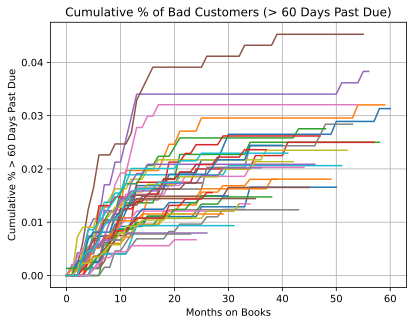

In [19]:
# plot vintage line chart
plt.rcParams['figure.facecolor'] = 'white'
vintage0 = vintage_wide.replace(0,np.nan)
lst = [i for i in range(0,61)]
vintage_wide[lst].T.plot(legend = False, grid = True, title = 'Cumulative % of Bad Customers (> 60 Days Past Due)')
#plt.axvline(30)
#plt.axvline(25)
#plt.axvline(20)
plt.xlabel('Months on Books')
plt.ylabel('Cumulative % > 60 Days Past Due')
plt.show()

### Window Analysis

관찰 창이 너무 짧으면, 사용자의 행동이 완전히 나타나지 않게 되므로  
데이터에 불필요한 잡음이 발생할 것이다.

관찰 창은 고려해야 할 중요한 매개변수.  
우리가 관찰하던 계정은 '계정 취소' 또는 '관찰 종료'에 의해 단축된다는 점을 반영.

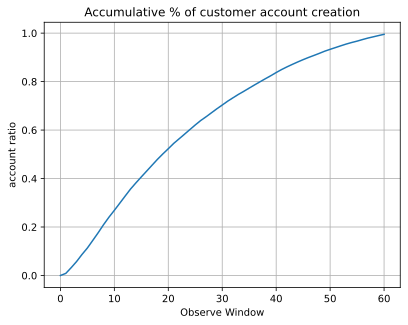

In [20]:
lst = []
for i in range(0,61):
    ratio = len(pivot_tb[pivot_tb['window'] < i]) / len(set(pivot_tb['ID']))
    lst.append(ratio)
    
pd.Series(lst).plot(legend = False, grid = True, title = 'Accumulative % of customer account creation')
plt.xlabel('Observe Window')
plt.ylabel('account ratio')
plt.show()

1. 60개월 관찰 창은 모든 신청자를 포함하고 있습니다.  
2. 20개월 관찰 창은 전체 데이터 중 약 52%의 기록만을 포함하고 있습니다.

In [21]:
credit

,ID,MONTHS_BALANCE,STATUS,open_month,end_month,window,overdue_60,month_on_book
44,5001713,-21,X,-21,0,21,0,0
43,5001713,-20,X,-21,0,21,0,1
42,5001713,-19,X,-21,0,21,0,2
41,5001713,-18,X,-21,0,21,0,3
40,5001713,-17,X,-21,0,21,0,4
...,...,...,...,...,...,...,...,...
1048549,5150487,-4,C,-29,0,29,0,25
1048548,5150487,-3,C,-29,0,29,0,26
1048547,5150487,-2,C,-29,0,29,0,27
1048546,5150487,-1,C,-29,0,29,0,28


In [22]:
import copy
credit_copy = copy.deepcopy(credit)

In [23]:
credit_copy

,ID,MONTHS_BALANCE,STATUS,open_month,end_month,window,overdue_60,month_on_book
44,5001713,-21,X,-21,0,21,0,0
43,5001713,-20,X,-21,0,21,0,1
42,5001713,-19,X,-21,0,21,0,2
41,5001713,-18,X,-21,0,21,0,3
40,5001713,-17,X,-21,0,21,0,4
...,...,...,...,...,...,...,...,...
1048549,5150487,-4,C,-29,0,29,0,25
1048548,5150487,-3,C,-29,0,29,0,26
1048547,5150487,-2,C,-29,0,29,0,27
1048546,5150487,-1,C,-29,0,29,0,28


In [24]:
credit_copy[credit_copy['STATUS'] == '3'].head()

,ID,MONTHS_BALANCE,STATUS,open_month,end_month,window,overdue_60,month_on_book
8913,5002126,-48,3,-55,0,55,1,7
8912,5002126,-47,3,-55,0,55,1,8
34912,5003267,-51,3,-53,0,53,1,2
34911,5003267,-50,3,-53,0,53,1,3
44246,5003712,-23,3,-37,0,37,1,14


In [25]:
len(credit_copy[credit_copy['STATUS'] == '3']['ID'].unique())

209

In [26]:
# ID = 5002126인 신용카드 사용자 살펴보기
credit_copy[credit_copy['ID'] == 5002126]

,ID,MONTHS_BALANCE,STATUS,open_month,end_month,window,overdue_60,month_on_book
8920,5002126,-55,0,-55,0,55,0,0
8919,5002126,-54,0,-55,0,55,0,1
8918,5002126,-53,X,-55,0,55,0,2
8917,5002126,-52,X,-55,0,55,0,3
8916,5002126,-51,1,-55,0,55,0,4
8915,5002126,-50,2,-55,0,55,1,5
8914,5002126,-49,2,-55,0,55,1,6
8913,5002126,-48,3,-55,0,55,1,7
8912,5002126,-47,3,-55,0,55,1,8
8911,5002126,-46,2,-55,0,55,1,9


In [27]:


def calculate_observe(credit, command):
    '''calculate observe window
    '''
    id_sum = len(set(pivot_tb['ID']))
    credit['status'] = 0
    exec(command)
    #credit.loc[(credit['STATUS'] == '4' )| (credit['STATUS'] == '5'), 'status'] = 1
    credit['month_on_book'] = credit['MONTHS_BALANCE'] - credit['open_month']
    minagg = credit[credit['status'] == 1].groupby('ID')['month_on_book'].min()
    minagg = pd.DataFrame(minagg)
    minagg['ID'] = minagg.index
    obslst = pd.DataFrame({'month_on_book':range(0,61), 'rate': None})
    lst = []
    for i in range(0,61):
        due = list(minagg[minagg['month_on_book']  == i]['ID'])
        lst.extend(due)
        obslst.loc[obslst['month_on_book'] == i, 'rate'] = len(set(lst)) / id_sum 
    return obslst['rate']

command = "credit.loc[(credit['STATUS'] == '0') | (credit['STATUS'] == '1') | (credit['STATUS'] == '2') | (credit['STATUS'] == '3' )| (credit['STATUS'] == '4' )| (credit['STATUS'] == '5'), 'status'] = 1"   
morethan1 = calculate_observe(credit, command)
command = "credit.loc[(credit['STATUS'] == '1') | (credit['STATUS'] == '2') | (credit['STATUS'] == '3' )| (credit['STATUS'] == '4' )| (credit['STATUS'] == '5'), 'status'] = 1"   
morethan30 = calculate_observe(credit, command)
command = "credit.loc[(credit['STATUS'] == '2') | (credit['STATUS'] == '3' )| (credit['STATUS'] == '4' )| (credit['STATUS'] == '5'), 'status'] = 1"
morethan60 = calculate_observe(credit, command)
command = "credit.loc[(credit['STATUS'] == '3' )| (credit['STATUS'] == '4' )| (credit['STATUS'] == '5'), 'status'] = 1"
morethan90 = calculate_observe(credit, command)
command = "credit.loc[(credit['STATUS'] == '4' )| (credit['STATUS'] == '5'), 'status'] = 1"
morethan120 = calculate_observe(credit, command)
command = "credit.loc[(credit['STATUS'] == '5'), 'status'] = 1"
morethan150 = calculate_observe(credit, command)

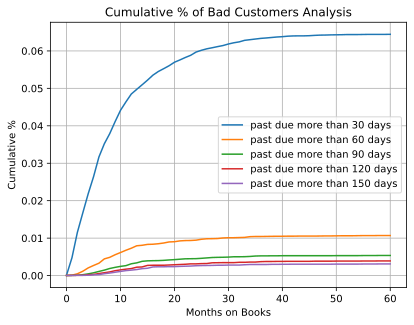

In [28]:
obslst = pd.DataFrame({'past due more than 30 days': morethan30,
                       'past due more than 60 days': morethan60,
                       'past due more than 90 days': morethan90,
                       'past due more than 120 days': morethan120,
                       'past due more than 150 days': morethan150
                        })

obslst.plot(grid = True, title = 'Cumulative % of Bad Customers Analysis')
plt.xlabel('Months on Books')
plt.ylabel('Cumulative %')
plt.show()

'open-month'기준으로 한 평균 버전의 vintage 그래프

1. 연체기간이 길수록 더 긴 관찰 창이 필요하다. ex) 150일 이상 연체된 경우, 첫번째 나쁜 고객이 나타날 때까지 최소 5개월 필요하다. 
2. 20개월 관찰 창이 대부분의 나쁜 고객을 커버할 수 있다.

### Overall Past-due Ratio것입니다.

**전체 연체율을 계산**

1일 연체, 20일 연체, 60일 연체, 90일 연체, 120일 연체, 150일 연체에 대해 각각 분석  
이 분석을 통해 누가 나쁜 고객인지를 파악할 수 있다.

1. 거의 87%의 사용자가 1일 이상 연체된 것으로 나타납니다. 이는 너무 흔하므로 기준으로 적절하지 않습니다.
   
2. 150일 연체는 어떨까요? 해당 기간까지 연체한 계정은 0.4%밖에 되지 않습니다. 이 기준을 사용하면 분석에서 많은 나쁜 고객을 놓칠 수 있습니다.  

이러한 테이블을 통해 어떤 기준이 나쁜 고객을 가장 잘 나타낼 것인지를 결정하는 데 도움이 될 것입니다.

In [29]:
credit0

,ID,MONTHS_BALANCE,STATUS,open_month,end_month,window
0,5001711,0,X,-3,0,3
1,5001711,-1,0,-3,0,3
2,5001711,-2,0,-3,0,3
3,5001711,-3,0,-3,0,3
4,5001712,0,C,-18,0,18
...,...,...,...,...,...,...
1048570,5150487,-25,C,-29,0,29
1048571,5150487,-26,C,-29,0,29
1048572,5150487,-27,C,-29,0,29
1048573,5150487,-28,C,-29,0,29


In [32]:
pivot_tb

MONTHS_BALANCE,ID,open_month,end_month,window
0,5001711,-3,0,3
1,5001712,-18,0,18
2,5001713,-21,0,21
3,5001714,-14,0,14
4,5001715,-59,0,59
...,...,...,...,...
45980,5150482,-28,-11,17
45981,5150483,-17,0,17
45982,5150484,-12,0,12
45983,5150485,-1,0,1


In [33]:
def calculate_rate(pivot_tb, command): 
    '''calculate bad customer rate
    '''
    credit0['status'] = None
    exec(command) # excuate input code
    sumagg = credit0.groupby('ID')['status'].agg(sum)
    pivot_tb = pd.merge(pivot_tb, sumagg, on = 'ID', how = 'left')
    pivot_tb.loc[pivot_tb['status'] > 1, 'status'] = 1
    rate = pivot_tb['status'].sum() / len(pivot_tb)
    return round(rate, 5)

command = "credit0.loc[(credit0['STATUS'] == '0') | (credit0['STATUS'] == '1') | (credit0['STATUS'] == '2') | (credit0['STATUS'] == '3' )| (credit0['STATUS'] == '4' )| (credit0['STATUS'] == '5'), 'status'] = 1"   
morethan1 = calculate_rate(pivot_tb, command)
command = "credit0.loc[(credit0['STATUS'] == '1') | (credit0['STATUS'] == '2') | (credit0['STATUS'] == '3' )| (credit0['STATUS'] == '4' )| (credit0['STATUS'] == '5'), 'status'] = 1"   
morethan30 = calculate_rate(pivot_tb, command)
command = "credit0.loc[(credit0['STATUS'] == '2') | (credit0['STATUS'] == '3' )| (credit0['STATUS'] == '4' )| (credit0['STATUS'] == '5'), 'status'] = 1"
morethan60 = calculate_rate(pivot_tb, command)
command = "credit0.loc[(credit0['STATUS'] == '3' )| (credit0['STATUS'] == '4' )| (credit0['STATUS'] == '5'), 'status'] = 1"
morethan90 = calculate_rate(pivot_tb, command)
command = "credit0.loc[(credit0['STATUS'] == '4' )| (credit0['STATUS'] == '5'), 'status'] = 1"
morethan120 = calculate_rate(pivot_tb, command)
command = "credit0.loc[(credit0['STATUS'] == '5'), 'status'] = 1"
morethan150 = calculate_rate(pivot_tb, command)

summary_dt = pd.DataFrame({'situation':['past due more than 1 day',
                               'past due more than 30 days',
                               'past due more than 60 days',
                               'past due more than 90 days',
                               'past due more than 120 days',
                               'past due more than 150 days'],
                      'bad customer ratio':[morethan1,
                               morethan30,
                               morethan60,
                               morethan90, 
                               morethan120,
                               morethan150, 
                      ]})
summary_dt

,situation,bad customer ratio
0,past due more than 1 day,0.87054
1,past due more than 30 days,0.11634
2,past due more than 60 days,0.01450
3,past due more than 90 days,0.00720
4,past due more than 120 days,0.00528
5,past due more than 150 days,0.00424


### Survival Analysis

의료, 생명과학, 공학, 금융 등 다양한 분야에서 사용되는 통계적 분석 방법  

1. 주로 시간에 따른 사건 발생률을 분석하는 데 사용된다.  
2. 사건이 발생하기 전까지의 시간(생존 시간)과 사건이 발생한 후의 시간을 모두 고려하여 분석한다.  

신용 카드 승인 예측에서 Survival analysis를 적용하면,  
고객이 신용 카드를 사용하기 시작한 후 얼마나 오랜 시간 동안 불량 고객으로 분류되는지를 분석 가능  

이를 통해 신용 카드를 사용하는 고객의 불량 예측 능력을 향상

#### Kaplan-Meier

Kaplan-Meier 추정량: 시간에 따른 사건 발생률을 비교하고 시각화할 수 있습니다.  
참고: https://blog.naver.com/sjloveu2/223062682684

In [39]:
credit

,ID,MONTHS_BALANCE,STATUS,open_month,end_month,window,overdue_60,month_on_book,status
44,5001713,-21,X,-21,0,21,0,0,0
43,5001713,-20,X,-21,0,21,0,1,0
42,5001713,-19,X,-21,0,21,0,2,0
41,5001713,-18,X,-21,0,21,0,3,0
40,5001713,-17,X,-21,0,21,0,4,0
...,...,...,...,...,...,...,...,...,...
1048549,5150487,-4,C,-29,0,29,0,25,0
1048548,5150487,-3,C,-29,0,29,0,26,0
1048547,5150487,-2,C,-29,0,29,0,27,0
1048546,5150487,-1,C,-29,0,29,0,28,0


        ID  month_on_book  truncate
0  5001713             21         0
1  5001715             59         0
2  5001717             21         0
3  5001718             38         0
4  5001719             42         0


Text(0, 0.5, 'survival rate')

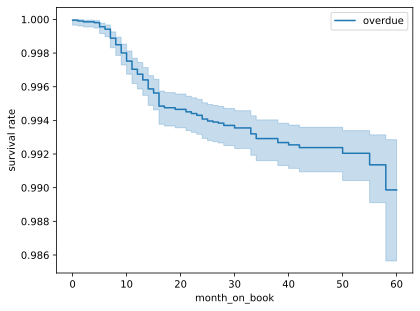

In [45]:
credit['truncate'] = credit.groupby('ID')['overdue_60'].transform('max')
truncate = credit.loc[credit['truncate']==1,]
not_trunc = credit.loc[credit['truncate']==0,]

dt1 = not_trunc.groupby('ID').agg({'month_on_book': ['max'],
                            'truncate':['max']
                           })
dt1.reset_index(inplace = True)
dt1.columns = ['ID','month_on_book','truncate']
dt2 = truncate.loc[truncate['status']==1,].groupby('ID').agg({'month_on_book': ['min'],
                            'truncate':['max']
                           })
dt2.reset_index(inplace = True)
dt2.columns = ['ID','month_on_book','truncate'] 
dt = pd.concat([dt1, dt2])

print(dt.head())

kmf = KaplanMeierFitter()
kmf.fit(dt['month_on_book'], event_observed=dt['truncate'], label='overdue')
kmf.plot()
plt.xlabel('month_on_book')
plt.ylabel('survival rate')

**해석 결과**

x축: 고객이 카드를 사용한 개월 수
y축: 고객의 생존 확률

x축의 특정 시점에서의 y값을 확인하여, 해당 시점까지 연체가 발생한 고객이 얼마나 생존하고 있는지를 파악
  
곡선이 급격하게 감소할수록 해당 시점에서 60일 이상 연체가 발생한 고객의 수가 많음을 의미

Text(0, 0.5, 'survival probability')

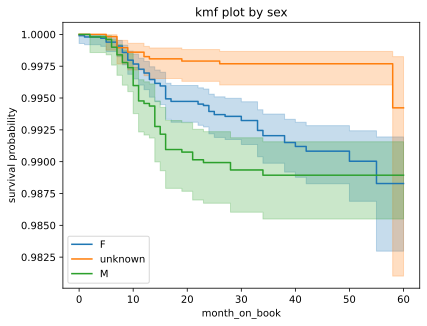

In [50]:
application = application[['ID', 'CODE_GENDER', 'FLAG_OWN_CAR', 'NAME_EDUCATION_TYPE','NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE']]
dt = pd.merge(dt, application, on = 'ID', how = 'left')
dt.fillna('unknown',inplace=True)

def plot_km(dt, timevar, truncate, groupby):
    '''plot km by subgroup
    '''
    plt.rcParams['figure.facecolor'] = 'white'
    kmf = KaplanMeierFitter()
    t = np.linspace(0, 60, 61)
    for i in dt[groupby].value_counts().index:
        kmf.fit(dt[dt[groupby] == i][timevar], event_observed=dt[dt[groupby] == i][truncate], timeline=t, label=i)
        ax = kmf.plot()

plot_km(dt, 'month_on_book', 'truncate', 'CODE_GENDER')
plt.title('kmf plot by sex')
plt.xlabel('month_on_book')
plt.ylabel('survival probability')

Text(0, 0.5, 'survival probability')

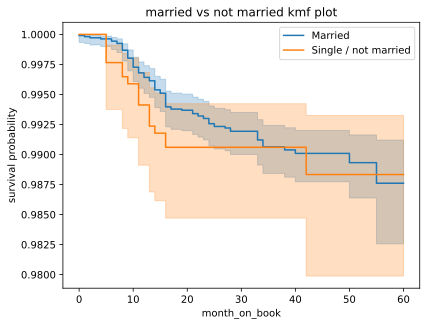

In [51]:
kmf = KaplanMeierFitter()
t = np.linspace(0, 60, 61)
kmf.fit(dt[dt['NAME_FAMILY_STATUS'] == 'Married']['month_on_book'], event_observed=dt[dt['NAME_FAMILY_STATUS'] == 'Married']['truncate'], timeline=t, label="Married")
ax = kmf.plot()

kmf.fit(dt[dt['NAME_FAMILY_STATUS'] == 'Single / not married']['month_on_book'], event_observed=dt[dt['NAME_FAMILY_STATUS'] == 'Single / not married']['truncate'], timeline=t, label="Single / not married")
ax = kmf.plot()
plt.title('married vs not married kmf plot')
plt.xlabel('month_on_book')
plt.ylabel('survival probability')